# Multi-agent Trajectory Planning

These examples demonstrate the use of RxInfer for trajectory planning in multi-agent situations. The animations show the inferred trajectories from probabilistic inference.
The examples shown in this notebook are based on https://github.com/biaslab/MultiAgentTrajectoryPlanning/blob/main/door.jl, prepared by [Michi-Tsubaki](https://github.com/Michi-Tsubaki), extended by [bvdmitri](https://github.com/bvdmitri). The original code is a part of the paper [Multi-Agent Trajectory Planning with NUV Priors](https://ieeexplore.ieee.org/document/10645034) by Bart van Erp.

## Introduction

This notebook demonstrates multi-agent trajectory planning using probabilistic inference with RxInfer.jl. In this example, we model multiple agents navigating through an environment with obstacles while trying to reach their respective goals. The planning problem is formulated as Bayesian inference, where:

- Agent states evolve according to linear dynamics
- Collision avoidance between agents and obstacles is encoded as probabilistic constraints
- Goal-seeking behavior is represented as prior distributions

By performing inference on this probabilistic model, we can compute optimal trajectories that balance goal-reaching with collision avoidance. The visualization shows how agents coordinate their movements to navigate efficiently through the environment.


In [1]:
using LinearAlgebra, RxInfer, Plots, LogExpFunctions

## Environment setup

To test our ideas, we need an environment to work with. We are going to create a simple environment consisting of a plane with boxes as obstacles. These boxes can be placed anywhere we want on the plane, allowing us to experiment with different configurations and scenarios. This flexible setup will help us evaluate how our multi-agent trajectory planning algorithms perform under various conditions and obstacle arrangements.

In [2]:
# A simple struct to represent a rectangle, which is defined by its center (x, y) and size (width, height)
Base.@kwdef struct Rectangle
    center::Tuple{Float64, Float64}
    size::Tuple{Float64, Float64}
end

function plot_rectangle!(p, rect::Rectangle)
    # Calculate the x-coordinates of the four corners
    x_coords = rect.center[1] .+ rect.size[1]/2 * [-1, 1, 1, -1, -1]
    # Calculate the y-coordinates of the four corners
    y_coords = rect.center[2] .+ rect.size[2]/2 * [-1, -1, 1, 1, -1]
    
    # Plot the rectangle with a black fill
    plot!(p, Shape(x_coords, y_coords), 
          label = "", 
          color = :black, 
          alpha = 0.5,
          linewidth = 1.5,
          fillalpha = 0.3)
end

# A simple struct to represent an environment, which is defined by a list of obctales,
# and in this demo the obstacles are just rectangles
Base.@kwdef struct Environment
    obstacles::Vector{Rectangle}
end

function plot_environment!(p, env::Environment)
    for obstacle in env.obstacles
        plot_rectangle!(p, obstacle)
    end
    return p
end

function plot_environment(env::Environment)
    p = plot(size = (800, 400), xlims = (-20, 20), ylims = (-20, 20), aspect_ratio = :equal)
    plot_environment!(p, env)
    return p
end

plot_environment (generic function with 1 method)

In the code above, we've defined two key structures for our environment:

1. `Rectangle`: A simple structure representing rectangular obstacles, defined by:
   - `center`: The (x,y) coordinates of the rectangle's center
   - `size`: The (width, height) of the rectangle
2. `Environment`: A structure that contains a collection of obstacles (rectangles)

We've also defined several plotting functions:
- `plot_rectangle!`: Adds a rectangle to an existing plot
- `plot_environment!`: Adds all obstacles in an environment to an existing plot
- `plot_environment`: Creates a new plot and displays the environment

These structures and functions provide the foundation for visualizing our 2D environment
where multi-agent trajectory planning will take place.

Let's create a couple of different environments to demonstrate multi-agent trajectory planning. You can experiment with different obstacle configurations by modifying the rectangle positions, sizes, and quantities. This will allow you to test how the agents navigate around various obstacle arrangements and interact with each other in different scenarios.




## Door environment

In this environment, we'll create a scenario resembling a doorway that agents must navigate through. The environment will consist of two wall-like obstacles with a narrow passage between them, simulating a door or gateway. This setup will test the agents' ability to coordinate when passing through a constrained space, which is a common challenge in multi-agent path planning. The narrow passage will force agents to negotiate the right-of-way and potentially wait for each other to pass through, demonstrating emergent cooperative behaviors.


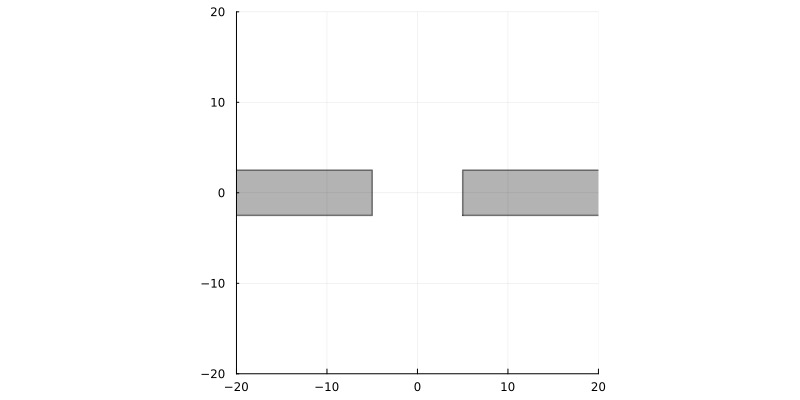

In [3]:
door_environment = Environment(obstacles = [
    Rectangle(center = (-40, 0), size = (70, 5)),
    Rectangle(center = (40, 0), size = (70, 5))
])

plot_environment(door_environment)

# Wall environment

In this environment, we'll create a scenario with a wall in the center that agents must navigate around. The environment will consist of a single elongated obstacle positioned in the middle of the space, forcing agents to choose whether to go above or below the wall. This setup will test the agents' ability to find efficient paths around obstacles and coordinate with each other to avoid congestion on either side of the wall. It represents a common scenario in multi-agent navigation where agents must make decisions about which route to take when faced with a barrier.

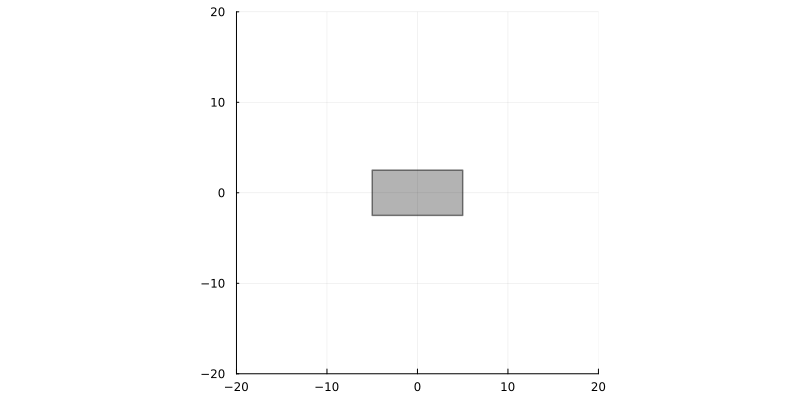

In [4]:
wall_environment = Environment(obstacles = [
    Rectangle(center = (0, 0), size = (10, 5))
])

plot_environment(wall_environment)

# Combined environment

In this environment, we'll combine the door and wall scenarios to create a more complex navigation challenge. This environment will feature both a narrow doorway that agents must pass through and a wall obstacle they need to navigate around. This combined setup will test the agents' ability to handle multiple types of obstacles in sequence, requiring more sophisticated path planning and coordination. Agents will need to negotiate the doorway and then decide which path to take around the wall, or vice versa depending on their starting and goal positions. This represents a more realistic scenario where environments often contain various types of obstacles that require different navigation strategies.


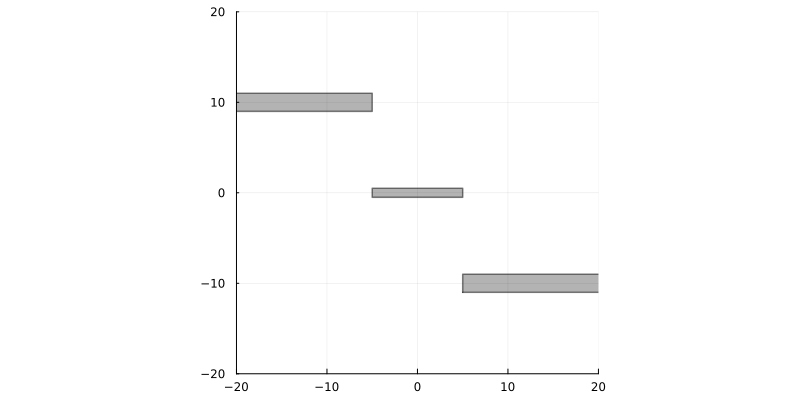

In [5]:
combined_environment = Environment(obstacles = [
    Rectangle(center = (-40, 10), size = (70, 2)),
    Rectangle(center = (40, -10), size = (70, 2)),
    Rectangle(center = (0, 0), size = (10, 1))
])

plot_environment(combined_environment)

Here are three environments together:

# Agent state

In this section, we define states and goals for our agents. Each agent has a starting position and target end position. These states will be used to drive agent movement through the environment. The trajectory planning algorithm uses this information to generate paths from start to destination while avoiding obstacles. This lets us simulate scenarios where multiple agents must coordinate to reach their goals without collisions. We start by first defining the necessary structures and functions for the goals.


In [40]:
# Agent state, encodes position and velocity
Base.@kwdef struct AgentState
    radius::Float64
    position::Tuple{Float64, Float64}
    velocity::Tuple{Float64, Float64}
end

function plot_agent_state!(p, state::AgentState; color::String="red", marker::Symbol=:circle, markersize::Float64=10, alpha::Float64=1.0)
    # Draw the agent as a circle with the given radius
    θ = range(0, 2π, 100)
    plot!(state.position[1] .+ state.radius .* cos.(θ), state.position[2] .+ state.radius .* sin.(θ); color=color, label="", alpha=alpha)
    return p
end

# Agent plan, encodes start and goal states
Base.@kwdef struct AgentPlan
    start::AgentState
    goal::AgentState
end

function plot_agent_plan!(p, plan::AgentPlan; color::String="red", markersize::Float64=10.0, alpha::Float64=1.0)
    plot_agent_state!(p, plan.start, color = color, markersize = markersize, alpha = alpha, marker = :circle)
    plot_agent_state!(p, plan.goal, color = color, markersize = markersize * 0.75, alpha = alpha * 0.25, marker = :star5)
end

plot_agent_plan! (generic function with 1 method)


Let see how does a single plan might look like in the first door environment. For this we will use two agents with different radius, as well as different start and goal positions.

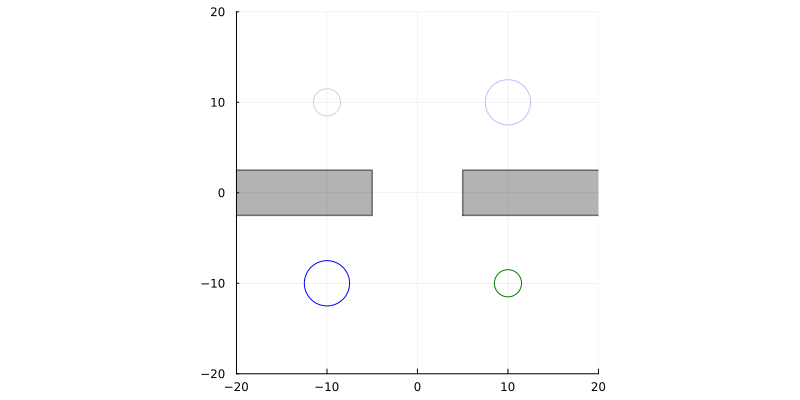

In [41]:
let pe = plot_environment(door_environment)
    agent_1_radius = 2.5
    agent_2_radius = 1.5

    # Left bottom corner
    agent_1_start = AgentState(position = (-10, -10), velocity = (0, 0), radius = agent_1_radius)
    # Right top corner
    agent_1_goal = AgentState(position = (10, 10), velocity = (0, 0), radius = agent_1_radius)
    # Right bottom corner
    agent_2_start = AgentState(position = (10, -10), velocity = (0, 0), radius = agent_2_radius)
    # Left top corner
    agent_2_goal = AgentState(position = (-10, 10), velocity = (0, 0), radius = agent_2_radius)

    agent_1_plan = AgentPlan(start = agent_1_start, goal = agent_1_goal)
    agent_2_plan = AgentPlan(start = agent_2_start, goal = agent_2_goal)
    
    plot_agent_plan!(pe, agent_1_plan, color = "blue")
    plot_agent_plan!(pe, agent_2_plan, color = "green")
end


The plot above illustrates our two agents with their start and goal positions in the door environment:

- **Blue Agent (Agent 1)**: This is the larger agent with a radius of 2.5 units. It starts in the left bottom corner (-10, -10) and needs to reach the right top corner (10, 10).

- **Green Agent (Agent 2)**: This is the smaller agent with a radius of 1.5 units. It starts in the right bottom corner (10, -10) and needs to reach the left top corner (-10, 10).

The agents' paths will cross in the middle of the environment, requiring coordination to avoid collision. The circles represent the agents' starting positions, while the stars indicate their goal positions.


## Next Steps

Now that we have set up our environment, defined our agents, and created utility functions, we are ready to build an RxInfer model to solve this multi-agent trajectory planning problem. In the following sections, we will:

1. Define a probabilistic model that captures the dynamics of our agents
2. Incorporate collision avoidance constraints between agents and obstacles using NUV priors
3. Use message passing to infer optimal trajectories
4. Visualize the resulting paths

This will demonstrate how probabilistic programming with RxInfer can elegantly solve complex planning problems while handling uncertainty and constraints in a principled way.


### Half space prior implementation

For our multi-agent trajectory planning model, we need to implement half-space priors to handle collision avoidance constraints. These priors allow us to model the requirement that agents must stay outside of obstacles and maintain safe distances from each other. The mathematical details and theoretical foundation of these half-space priors can be found in the paper referenced at the beginning of this notebook. The implementation below defines the necessary node and message-passing rules for incorporating these constraints into our probabilistic model.


In [37]:
# Define the probabilistic model for obstacles using halfspace constraints
struct Halfspace end

@node Halfspace Stochastic [out, a, σ2, γ]

# rule specification
@rule Halfspace(:out, Marginalisation) (q_a::PointMass, q_σ2::PointMass, q_γ::PointMass) = begin
    return NormalMeanVariance(mean(q_a) + mean(q_γ) * mean(q_σ2), mean(q_σ2))
end

@rule Halfspace(:σ2, Marginalisation) (q_out::UnivariateNormalDistributionsFamily, q_a::PointMass, q_γ::PointMass, ) = begin
    return PointMass( 1 / mean(q_γ) * sqrt(abs2(mean(q_out) - mean(q_a)) + var(q_out)))
end

### Distance functions for collision avoidance

In addition to the halfspace priors, we need to implement distance functions to properly handle collision avoidance between agents and obstacles. These functions will calculate the distance between agents and obstacles, which is essential for determining when collision avoidance constraints should be activated. The distance functions will be used to ensure that agents maintain safe distances from each other and from obstacles in the environment. In the next section, we'll define utility functions that include these distance calculations for different geometric shapes like rectangles and circles.


In [44]:
softmin(x; l=10) = -logsumexp(-l .* x) / l

# state here is a 4-dimensional vector [x, y, vx, vy]
function distance(r::Rectangle, state)
    if abs(state[1] - r.center[1]) > r.width / 2 || abs(state[2] - r.center[2]) > r.height / 2
        # outside of rectangle
        dx = max(abs(state[1] - r.center[1]) - r.width / 2, 0)
        dy = max(abs(state[2] - r.center[2]) - r.height / 2, 0)
        return sqrt(dx^2 + dy^2)
    else
        # inside rectangle
        return max(abs(state[1] - r.center[1]) - r.width / 2, abs(state[2] - r.center[2]) - r.height / 2)
    end
end

function distance(env::Environment, state)
    return softmin([distance(obstacle, state) for obstacle in env.obstacles])
end

distance (generic function with 2 methods)

We use the `softmin` function to create a smooth approximation of the minimum distance between an agent and multiple obstacles. Unlike the regular `min` function which returns the exact minimum value, `softmin` produces a differentiable approximation that considers all distances with a weighted average, heavily biased toward the smallest values.

The parameter `l` controls the "sharpness" of the approximation - with larger values making the function behave more like the true minimum. This smoothness is particularly valuable in optimization contexts as it:

1. Avoids discontinuities that could cause numerical issues during inference
2. Provides gradient information from all obstacles, not just the closest one
3. Creates a more stable optimization landscape for trajectory planning

When calculating the distance between an agent and the environment, `softmin` helps create a continuous repulsive field around all obstacles, allowing for more natural avoidance behaviors.


## Define utility functions

In [45]:
begin
    
	ReactiveMP.constrain_form(pmconstraint::RxInfer.PointMassFormConstraint, distribution::MultivariateNormalDistributionsFamily) = mean(distribution) 

	ReactiveMP.prod(::GenericProd, left::Distribution, right::PointMass{Float64}) = right

end;

## Model specification

In [46]:
function g(environment, radius, state)
	return distance(environment, state) - radius
end;

function h(environment, radiuses, states...)
	# Calculate pairwise distances between all agents
	distances = Float64[]
	n = length(states)
	
	for i in 1:n
		for j in (i+1):n
			push!(distances, norm(states[i] - states[j]) - radiuses[i] - radiuses[j])
		end
	end
	
	return softmin(distances)
end

h (generic function with 1 method)

In [56]:
# Define model
@model function door_model(nr_steps, environment, radiuses, γ, A, B, C, goals)

    local y

    nr_agents = length(radiuses)

    # single agent models
    for k in 1:nr_agents

        # prior on state
        x[k, 1] ~ MvNormalMeanCovariance(zeros(4), 1e2I)

        for t in 1:nr_steps

            # prior on controls
            u[k, t] ~ MvNormalMeanCovariance(zeros(2), 1e-1I)

            # state transition
            x[k, t+1] ~ A * x[k, t] + B * u[k, t]

            # observation model
            y[k, t] ~ C * x[k, t+1]

            # environmental distance
            zσ2[k, t] ~ GammaShapeRate(3 / 2, γ^2 / 2)
            z[k, t] ~ g(environment, radiuses[k], y[k, t])
            z[k, t] ~ Halfspace(0, zσ2[k, t], γ)

        end

        # goal priors (indexing reverse due to definition)
        goals[1, k] ~ MvNormalMeanCovariance(x[k, 1], 1e-5I)
        goals[2, k] ~ MvNormalMeanCovariance(x[k, nr_steps+1], 1e-5I)

    end

    for t = 1:nr_steps

        # observation constraint
        dσ2[t] ~ GammaShapeRate(3 / 2, γ^2 / 2)
        d[t] ~ h(in = [environment, radiuses, y[:, t]...])
        d[t] ~ Halfspace(0, dσ2[t], γ)

    end

end;

## Constraint specification

In [57]:
@constraints function door_constraints()
	q(d, dσ2) = q(d)q(dσ2)
	q(z, zσ2) = q(z)q(zσ2)
end;

## Probabilistic inference
### Settings

In [58]:
# Define meta model
door_meta = @meta begin 
    h() -> Linearization(),
	g() -> Linearization()
end;

In [59]:
nr_steps = 50

50

In [60]:
nr_iterations = 1500

1500

In [61]:
# Define constant variables
begin
	ΔT = 1
	A = [1 ΔT 0 0; 
		0 1 0 0; 
		0 0 1 ΔT; 
		0 0 0 1]
	B = [0 0; 
		ΔT 0; 
		0 0; 
		0 ΔT]
	C = [1 0 0 0; 
		0 0 1 0]
	γ = 1
end;

In [62]:
# Initialize variables
init = @initialization begin

    q(dσ2) = repeat([PointMass(1)], nr_steps)
    q(zσ2) = repeat([PointMass(1)], 4, nr_steps)
    q(u) = repeat([PointMass(0)], nr_steps)

	μ(x) = MvNormalMeanCovariance(randn(4), 100I)
	μ(y) = MvNormalMeanCovariance(randn(2), 100I)

end

Initial state: 
  q(dσ2) = PointMass{Int64}[PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1)  …  PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1), PointMass{Int64}(1)]
  q(zσ2) = PointMass{Int64}[PointMass{Int64}(1) PointMass{Int64}(1) … PointMass{Int64}(1) PointMass{Int64}(1); PointMass{Int64}(1) PointMass{Int64}(1) … PointMass{Int64}(1) PointMass{Int64}(1); PointMass{Int64}(1) PointMass{Int64}(1) … PointMass{Int64}(1) PointMass{Int64}(1); PointMass{Int64}(1) PointMass{Int64}(1) … PointMass{Int64}(1) PointMass{Int64}(1)]
  q(u) = PointMass{Int64}[PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), PointMass{Int64}(0), 

> **Note:** In RxInfer version 2, constants were specified using constvar or as keyword arguments in model functions, but in RxInfer versions 3 and 4, they are specified as arguments outside the function.
Also, in RxInfer version 2, variables were initialized inside the inference function, but now we use the initialization macro instead.

### Inference

In [63]:
results = infer(
	model 			= door_model(environment = door_environment, radiuses = [2.5, 1.5], nr_steps = nr_steps, γ = γ, A = A, B = B, C = C),
	data  			= ( goals = goals, ),
	initialization  = init,
	constraints 	= door_constraints(),
	meta 			= door_meta,
	iterations 		= nr_iterations,
	returnvars 		= KeepLast(), 
	options = ( limit_stack_depth = 300, )
)

┌ Error: We encountered an error during inference, here are some helpful resources to get you back on track:
│ 
│ 1. Check our Sharp bits documentation which covers common issues:
│ https://docs.rxinfer.ml/stable/manuals/sharpbits/overview/
│ 2. Browse our existing discussions - your question may already be answered:
│ https://github.com/ReactiveBayes/RxInfer.jl/discussions
│ 3. Take inspiration from our set of examples:
│ https://examples.rxinfer.ml/
│ 
│ Still stuck? We'd love to help! You can:
│ - Start a discussion for questions and help. Feedback and questions from new users is also welcome! If you are stuck, please reach out and we will solve it together.
│ https://github.com/ReactiveBayes/RxInfer.jl/discussions
│ - Report a bug or request a feature:
│ https://github.com/ReactiveBayes/RxInfer.jl/issues
│ - (Optional) Share your session data with `RxInfer.share_session_data()` to help us better understand the issue
│ https://docs.rxinfer.ml/stable/manuals/telemetry/
│ 
│ Note that

ErrorException: type Rectangle has no field width

> **Note:** The syntax of this infer function (function name and initialization method) differs between RxInfer version 2 and 4. See http://docs.rxinfer.ml/stable/manuals/migration-guide-v2-v3/ .

## Results

This section shows the results of inference.

In [16]:
animation = @animate for t in 1:nr_steps
	plot(size = (0.8*600, 600), legend=false)

	plot!(
		map(x -> mean(x)[1], results.posteriors[:y][1,1:t]),
		map(x -> mean(x)[2], results.posteriors[:y][1,1:t]);
		color="red", linestyle=:dash
	)
	plot!(
		map(x -> mean(x)[1], results.posteriors[:y][2,1:t]),
		map(x -> mean(x)[2], results.posteriors[:y][2,1:t]);
		color="blue", linestyle=:dash
	)
	plot!(
		map(x -> mean(x)[1], results.posteriors[:y][3,1:t]),
		map(x -> mean(x)[2], results.posteriors[:y][3,1:t]);
		color="orange", linestyle=:dash
	)
	plot!(
		map(x -> mean(x)[1], results.posteriors[:y][4,1:t]),
		map(x -> mean(x)[2], results.posteriors[:y][4,1:t]);
		color="green", linestyle=:dash
	)

	draw_circle!(mean(results.posteriors[:y][1,t]), radius; color="red", label="")
	draw_circle!(mean(results.posteriors[:y][2,t]), radius; color="blue", label="")
	draw_circle!(mean(results.posteriors[:y][3,t]), radius; color="orange", label="")
	draw_circle!(mean(results.posteriors[:y][4,t]), radius; color="green", label="")

	draw_rectangle!(environment[1]; label="", color="black", alpha=0.5)
	draw_rectangle!(environment[2]; label="", color="black", alpha=0.5)

	scatter!([goals[2,1][1]], [goals[2,1][3]], color="red", label="", marker=:star5, markersize=10)
	scatter!([goals[2,2][1]], [goals[2,2][3]], color="blue", label="", marker=:star5, markersize=10)
	scatter!([goals[2,3][1]], [goals[2,3][3]], color="orange", label="", marker=:star5, markersize=10)
	scatter!([goals[2,4][1]], [goals[2,4][3]], color="green", label="", marker=:star5, markersize=10)
	
	xlims!(-20, 20)
	ylims!(-25, 25)
		
end

# assign the path to save the image
gif(animation, "result.gif", fps = 15);

┌ Info: Saved animation to /Users/bvdmitri/.julia/dev/RxInferExamples.jl/examples/Advanced Examples/Multi-agent Trajectory Planning/result.gif
└ @ Plots /Users/bvdmitri/.julia/packages/Plots/Ec1L1/src/animation.jl:156


![](result.gif)